**Task 3**: Now try to explore your processed version of the 995K dataset. Make at least three non-trivial observations/discoveries about the data. These observations could be related to outliers, artefacts, or even better: genuinely interesting patterns in the data that could potentially be used for fake-news detection. Examples of simple observations could be how many missing values there are in particular columns - or what the distribution over domains is. Be creative!

- Describe how you ended up representing the FakeNewsCorpus dataset (for instance with a Pandas dataframe). Argue for why you chose this design.
- Did you discover any inherent problems with the data while working with it?
- Report key properties of the data set - for instance through statistics or visualization.

The exploration can include (but need not be limited to):

- counting the number of URLs in the content
- counting the number of dates in the content
- counting the number of numeric values in the content
- determining the 100 more frequent words that appear in the content
plot the frequency of the 10000 most frequent words (any interesting patterns?)
- run the analysis in point 4 and 5 both before and after removing stopwords and applying stemming: do you see any difference?

In [34]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
import ast

cleaned_file = "cleaned_file.csv"
chunksize = 25000  
cleaned_file_csv = pd.read_csv("cleaned_file.csv")
cleaned_file_csv.head(5)

# Columns to analyze for missing metadata
metadata_cols = ['authors', 'meta_keywords', 'meta_description', 'tags', 'summary']

# Accumulators for initial observations
total_rows = 0
missing_counts_acc = None
domain_counts_acc = {}
type_counts_acc = {}
author_counts_acc = {}
error_count_acc = 0
content_lengths = []

# Accumulators for content analysis
total_urls = 0
total_dates = 0
total_emails = 0
word_counter = Counter()

# Process the CSV in chunks
for chunk in pd.read_csv(cleaned_file, chunksize=chunksize, low_memory=False):
    total_rows += len(chunk)
    
    # Observation 1: Missing values for metadata columns 
    chunk_missing = chunk[metadata_cols].isnull().sum()
    if missing_counts_acc is None:
        missing_counts_acc = chunk_missing
    else:
        missing_counts_acc += chunk_missing

    # Observation 2: Domain distribution 
    chunk_domain_counts = chunk['domain'].value_counts()
    for domain, count in chunk_domain_counts.items():
        domain_counts_acc[domain] = domain_counts_acc.get(domain, 0) + count

    # Observation 3: Type distribution
    chunk_type_counts = chunk["type"].value_counts()
    for type_, count in chunk_type_counts.items():
        type_counts_acc[type_] = type_counts_acc.get(type_, 0) + count

    # Observation 4: Author distribution
    chunk_author_counts = chunk["authors"].value_counts()
    for author, count in chunk_author_counts.items():
        author_counts_acc[author] = author_counts_acc.get(author, 0) + count

    # Observation 5: Content Artifacts and Anomalies
    chunk['content'] = chunk['content'].astype(str)
    # Detect rows containing "error"
    error_mask = chunk['content'].str.contains(r"\berror\b", case=False, regex=True, na=False)
    error_count_acc += error_mask.sum()
    
    # Counting URLs, dates, numeric values, and aggregating words
    total_urls += chunk['content'].str.count('<URL>').sum()
    total_dates += chunk['content'].str.count('<DATE>').sum()
    total_emails += chunk['content'].str.count('<EMAIL>').sum()
    word_regex = r'\w+'
    
    # Aggregate word counts for the top frequent words
    combined_text = " ".join(chunk['content'].tolist())
    words = re.findall(word_regex, combined_text)
    word_counter.update(words)

# Results after processing
print("Total rows processed:", total_rows)

print("\nMissing values in metadata columns (count):")
print(missing_counts_acc)
print("\nMissing values in metadata columns (percentage):")
print((missing_counts_acc / total_rows * 100).round(2))

print("\nDomain distribution (top 10):")
domain_series = pd.Series(domain_counts_acc).sort_values(ascending=False)
print(domain_series.head(10))

print("\nType distribution (top 10):")
type_series = pd.Series(type_counts_acc).sort_values(ascending=False)
print(type_series.head(10))

print("\nAuthor distribution (top 10):")
author_series = pd.Series(author_counts_acc).sort_values(ascending=False)
print(author_series.head(10))

# Top 100 most frequent words
top_100_words = word_counter.most_common(100)
print("\nTop 100 most frequent words:")
for word, count in top_100_words:
    print(f"{word}: {count}")

print("\nTotal articles with 'error' in content:", error_count_acc)

# Additional content analysis results
print("\nTotal URLs found in content:", total_urls)
print("Total dates found in content:", total_dates)
print("Total total_emails found in content:", total_emails)


C:\Users\simon\AppData\Local\Temp\ipykernel_14560\1760392706.py:9: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  cleaned_file_csv = pd.read_csv("cleaned_file.csv")


Total rows processed: 995000

Missing values in metadata columns (count):
authors             442757
meta_keywords        38790
meta_description    525106
tags                764081
summary             995000
dtype: int64

Missing values in metadata columns (percentage):
authors              44.50
meta_keywords         3.90
meta_description     52.77
tags                 76.79
summary             100.00
dtype: float64

Domain distribution (top 10):
nytimes.com           176144
beforeitsnews.com      91468
dailykos.com           77640
express.co.uk          55983
nationalreview.com     37377
sputniknews.com        37229
abovetopsecret.com     27947
wikileaks.org          23699
www.newsmax.com        12688
www.ammoland.com       11129
dtype: int64

Type distribution (top 10):
reliable      218564
political     194518
bias          133232
fake          104883
conspiracy     97314
rumor          56445
unknown        43534
unreliable     35332
clickbait      27412
junksci        14040
dtype

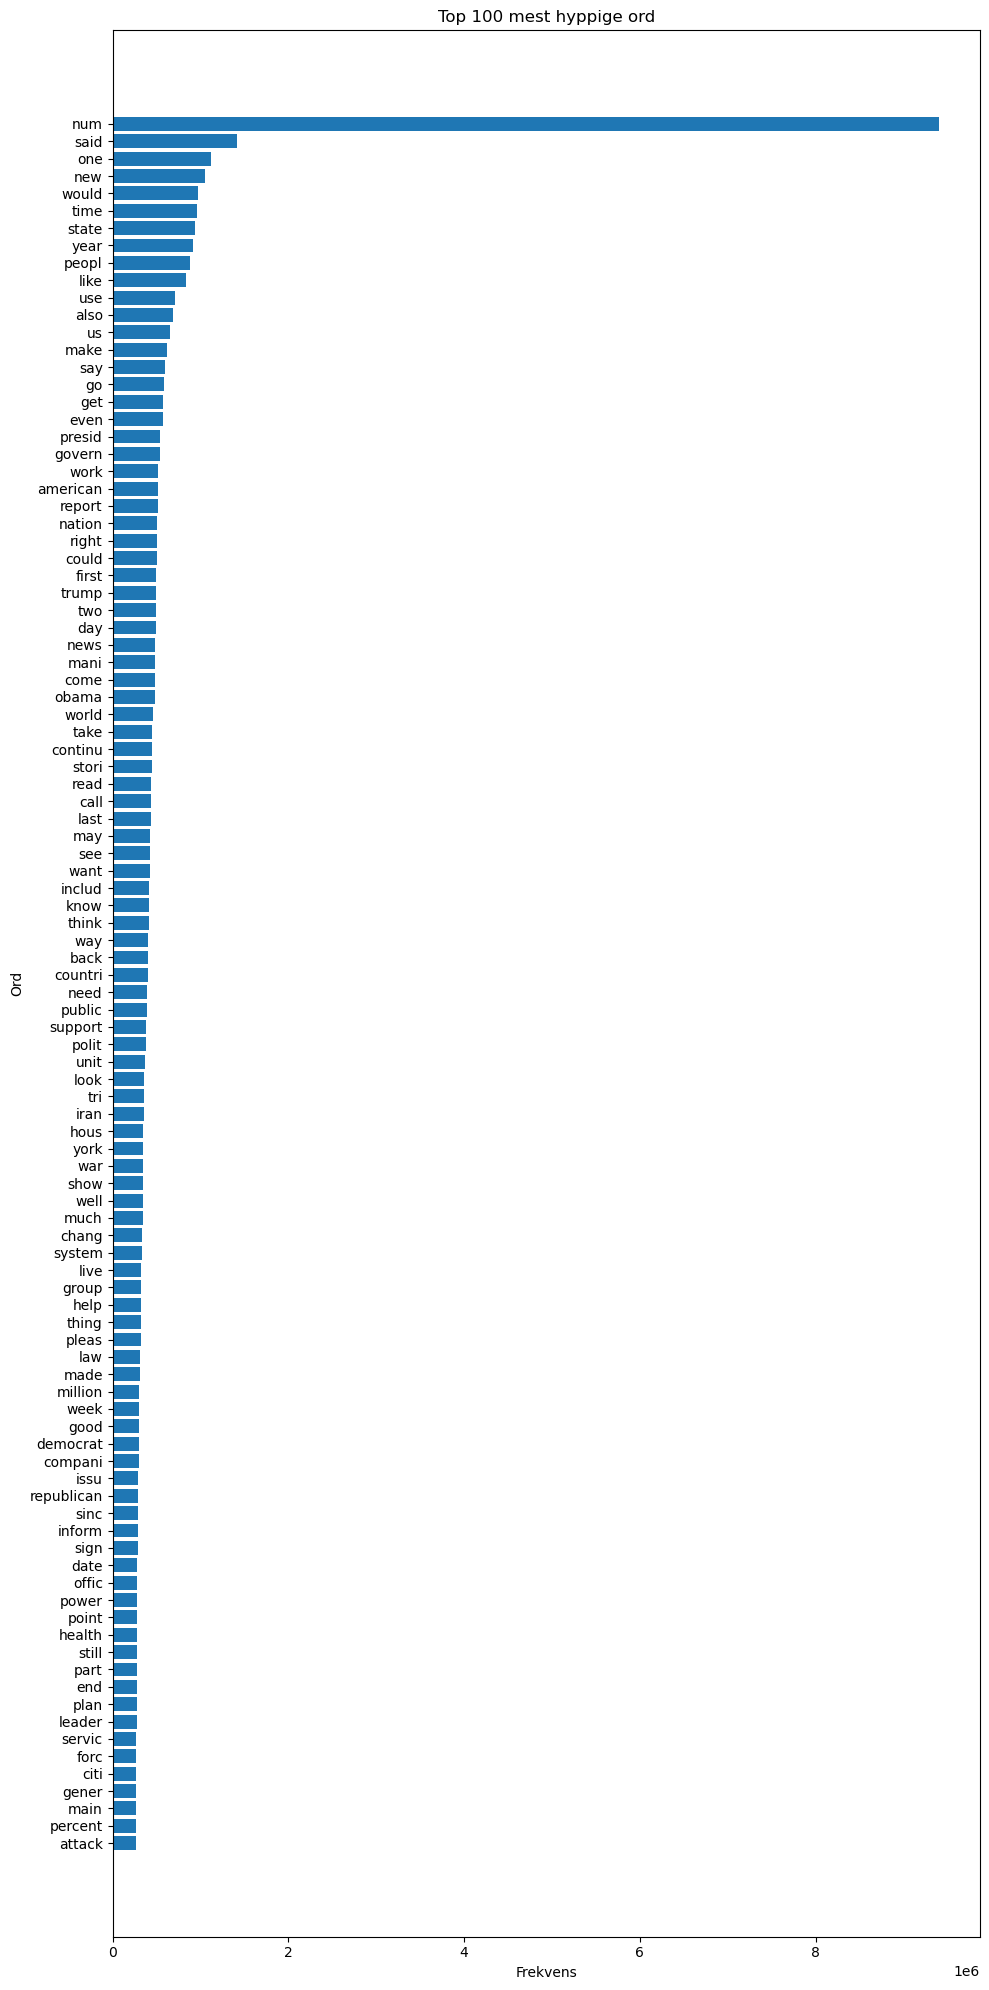

In [ ]:
""" 
Top-ord in "content" distribution barplot
"""
cleaned_word_counter = Counter()

# Læs tokens og saml frekvenser
for chunk in pd.read_csv(cleaned_file, chunksize=chunksize, low_memory=False):
    if 'content' in chunk.columns:
        # Konverter string-repræsentation af lister til faktiske lister
        chunk['content'] = chunk['content'].dropna().apply(ast.literal_eval)

        for content in chunk['content']:
            if isinstance(content, list):
                cleaned_word_counter.update(content)

# Eksempeldata
top_100 = cleaned_word_counter.most_common(100)
words, freqs = zip(*top_100)

plt.figure(figsize=(10, 20))
plt.barh(words, freqs)
plt.xlabel("Frekvens")
plt.ylabel("Ord")
plt.title("Top 100 mest hyppige ord")
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()

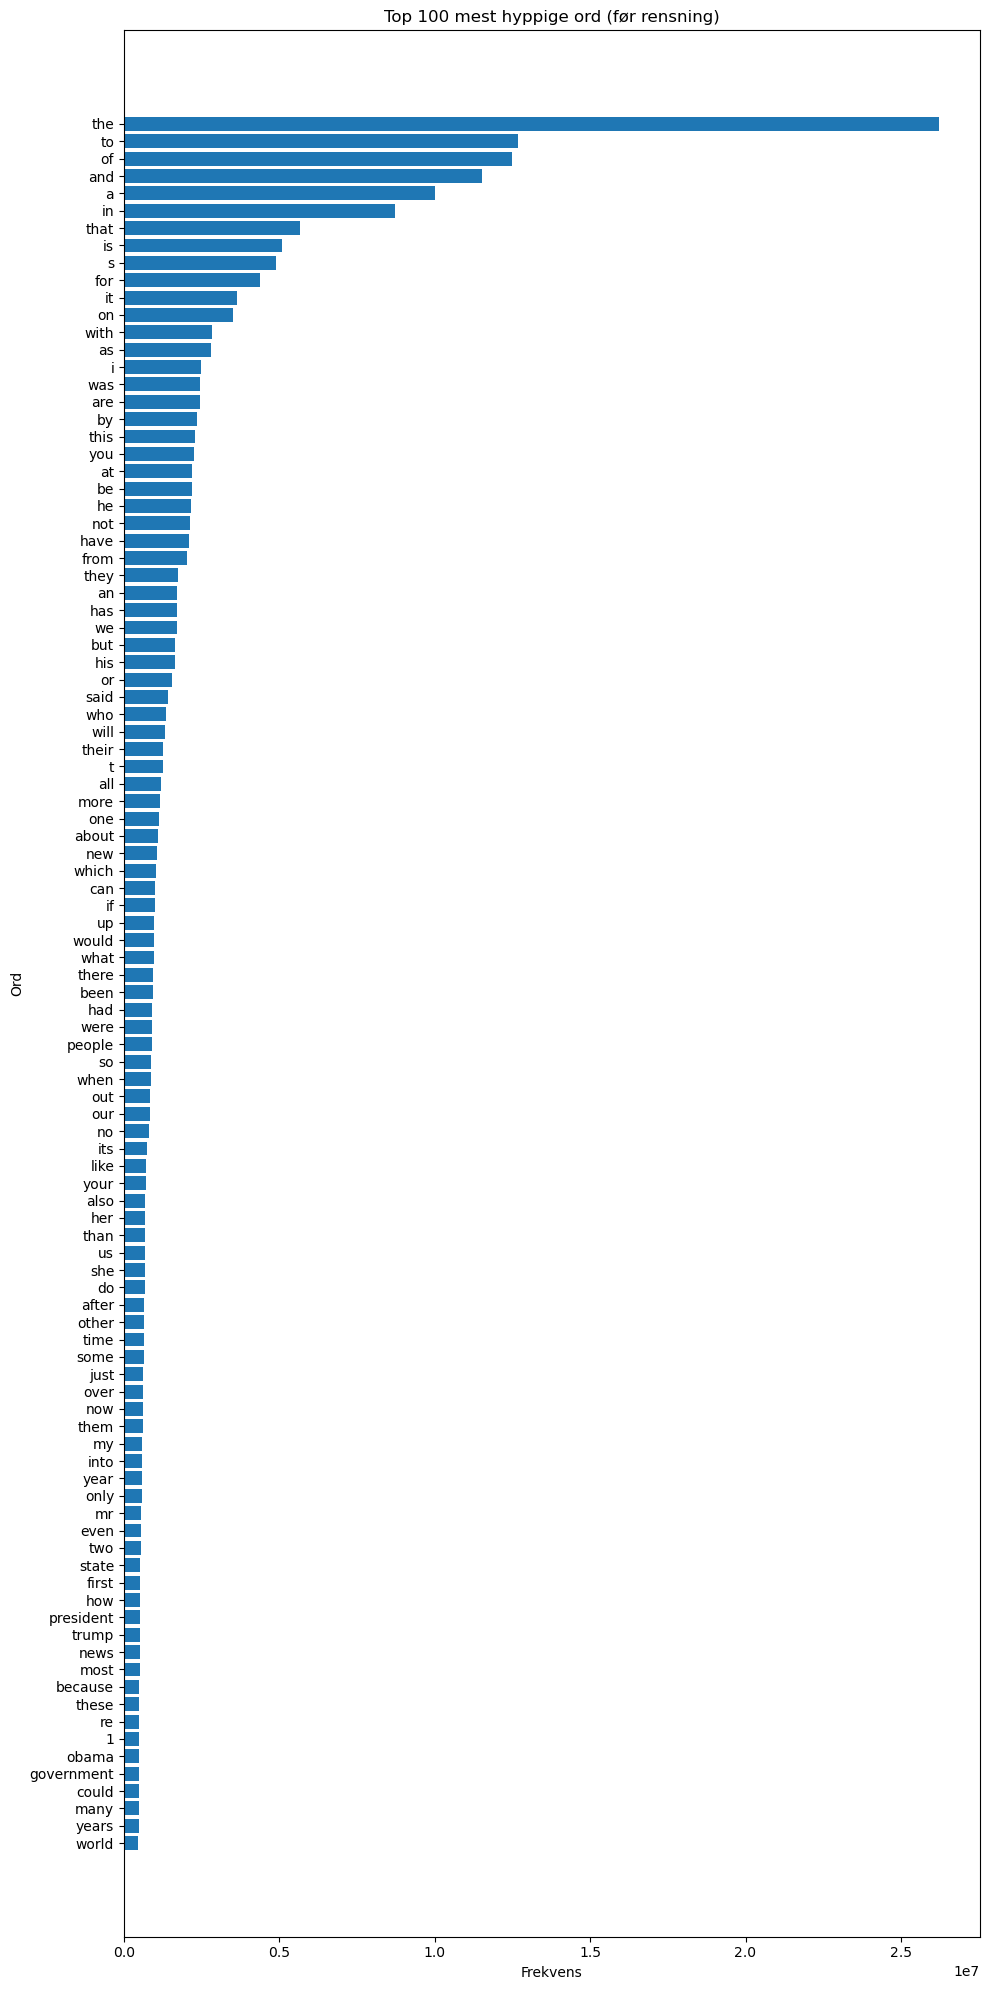

In [8]:
"""
Top-ord in "content" distribution barplot for the "raw" file 
"""
raw_word_counter = Counter()

for chunk in pd.read_csv(file_path, chunksize=chunksize, low_memory=False):
    if 'content' in chunk.columns:
        for text in chunk['content'].dropna().astype(str):
            tokens = re.findall(r'\w+', text.lower())  # enkel tokenisering
            raw_word_counter.update(tokens)

top_100 = raw_word_counter.most_common(100)
words, freqs = zip(*top_100)

plt.figure(figsize=(10, 20))
plt.barh(words, freqs)
plt.xlabel("Frekvens")
plt.ylabel("Ord")
plt.title("Top 100 mest hyppige ord (før rensning)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

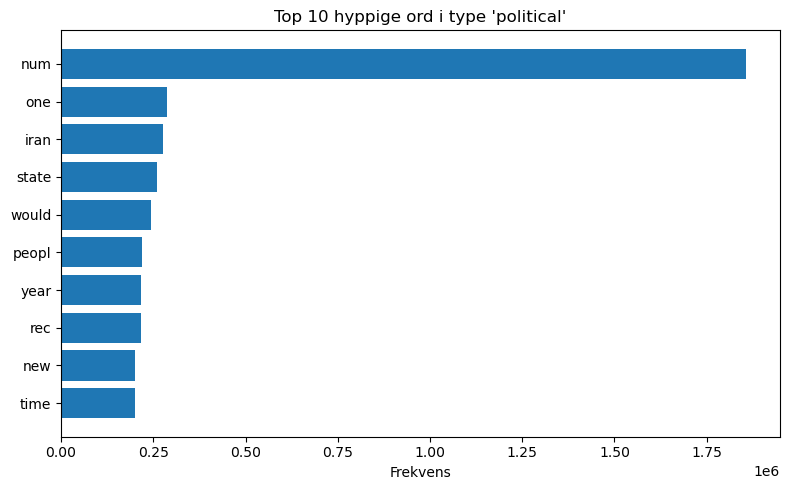

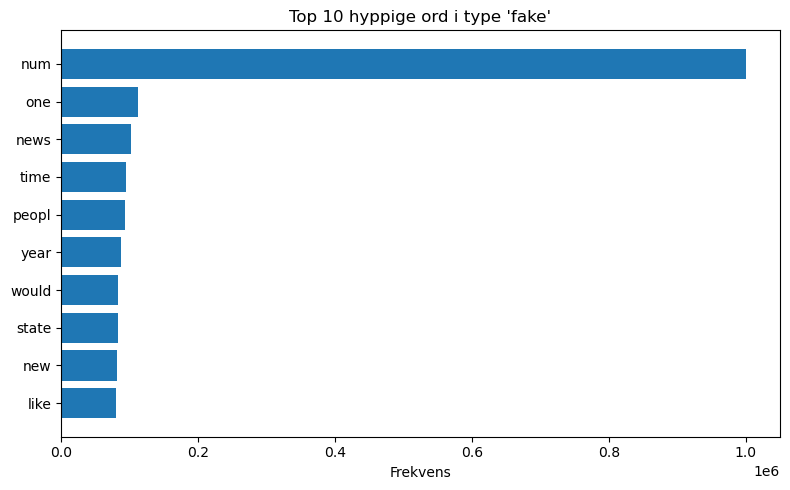

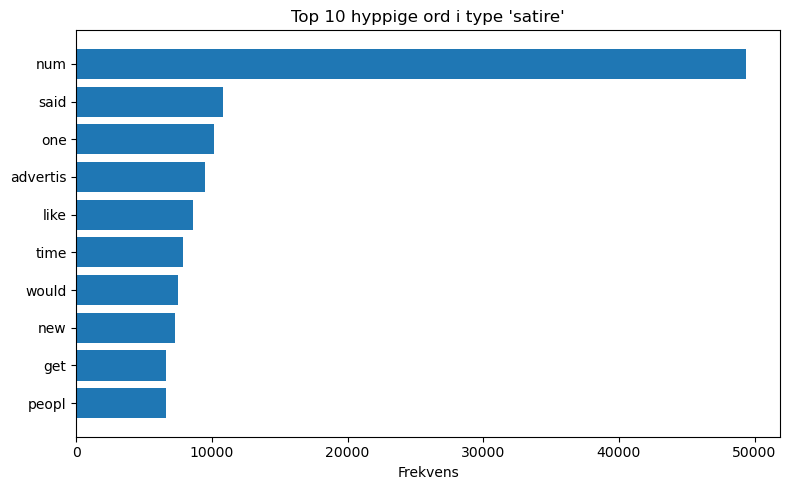

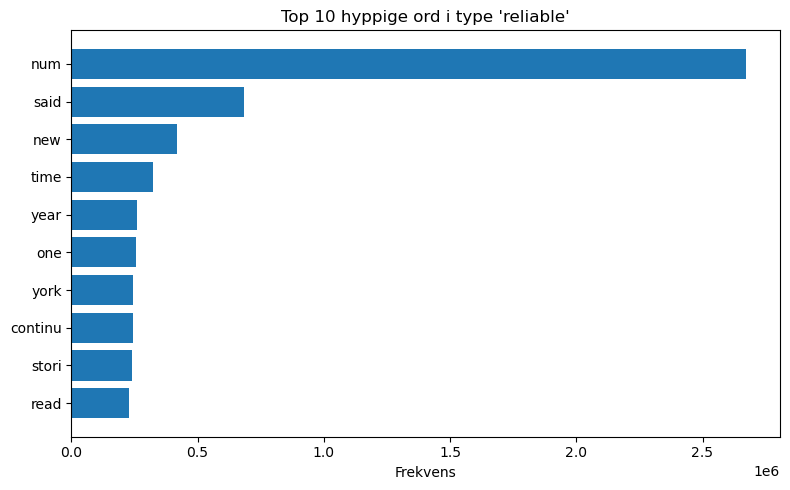

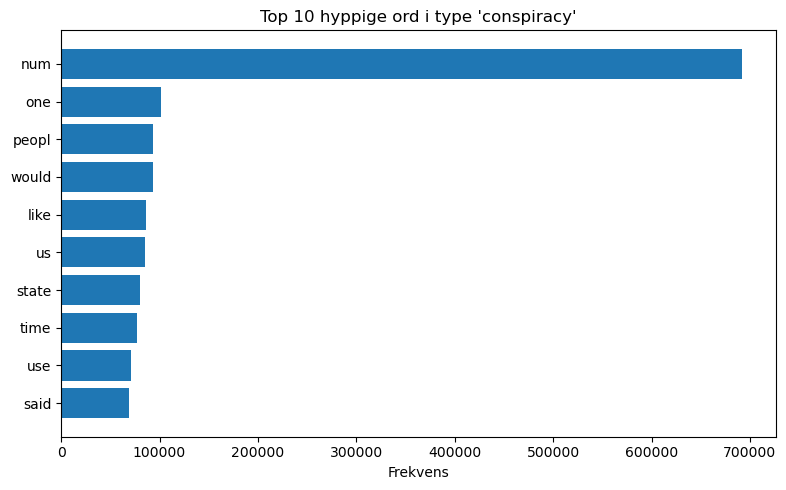

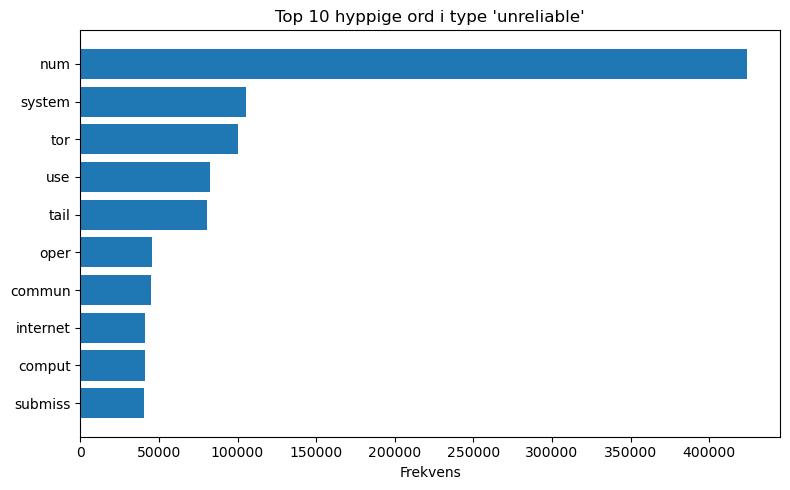

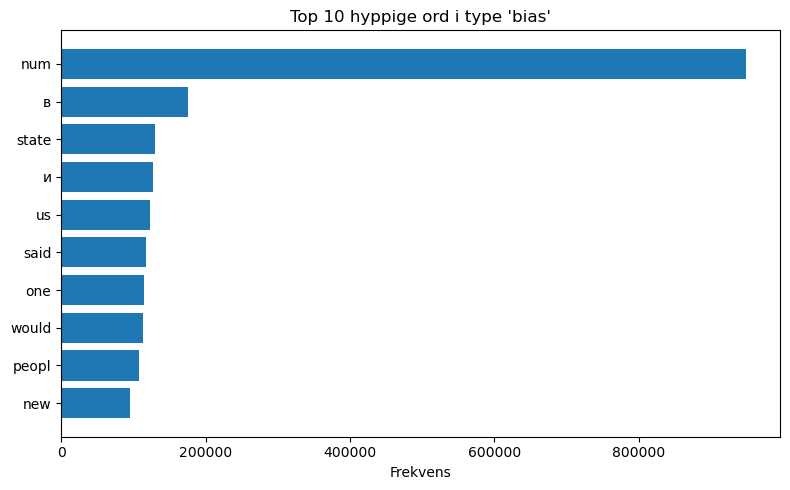

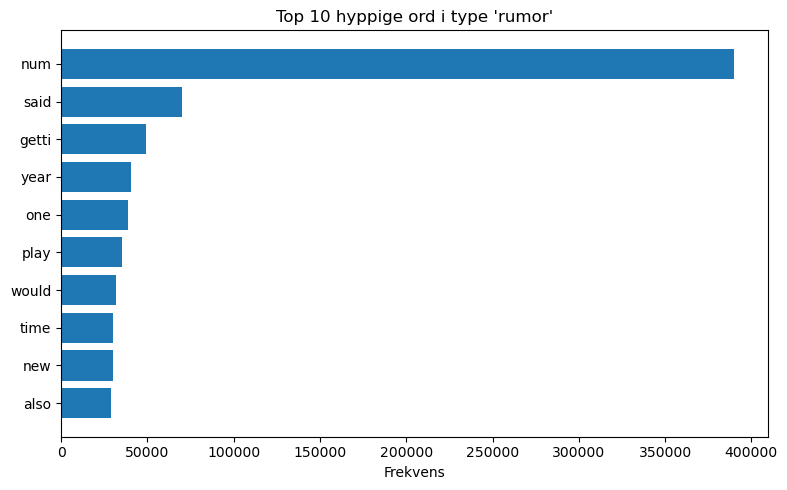

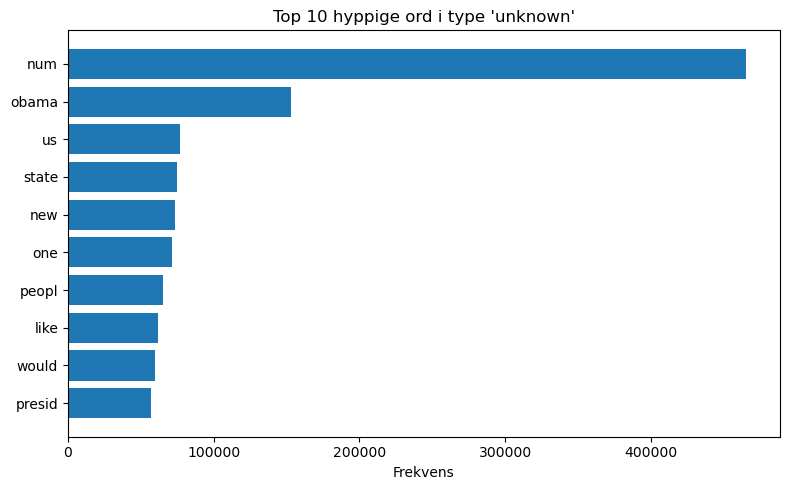

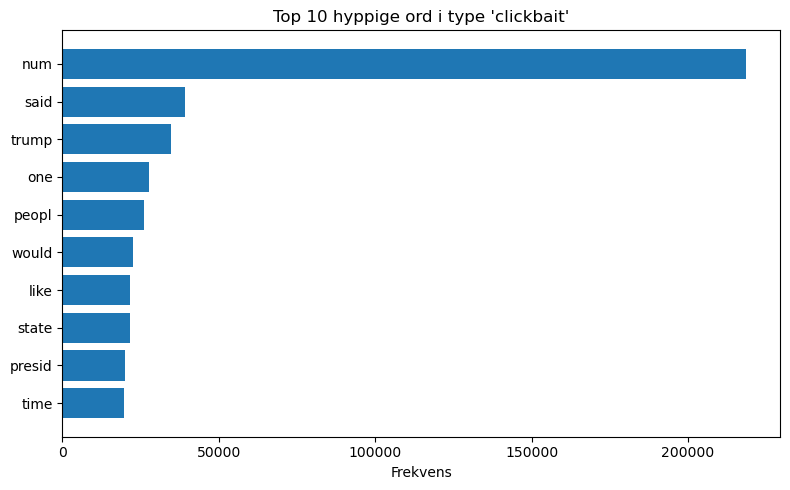

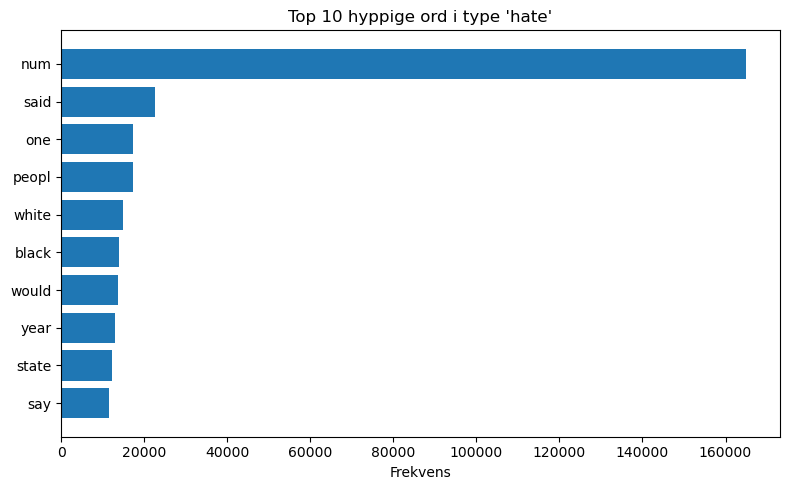

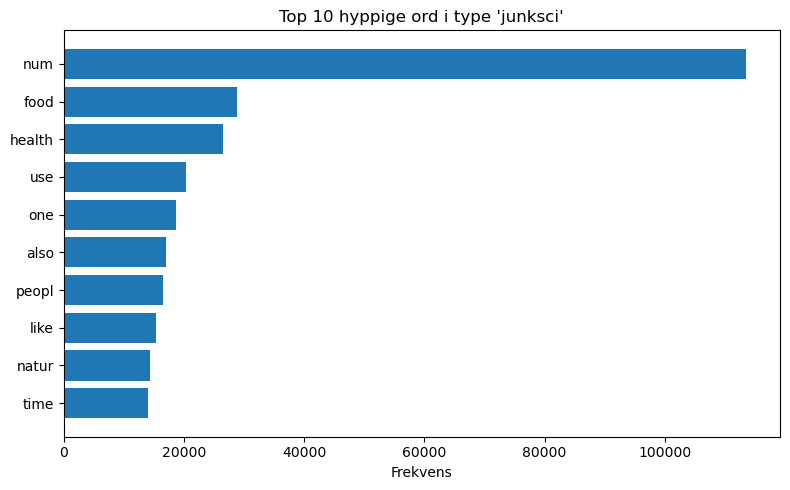

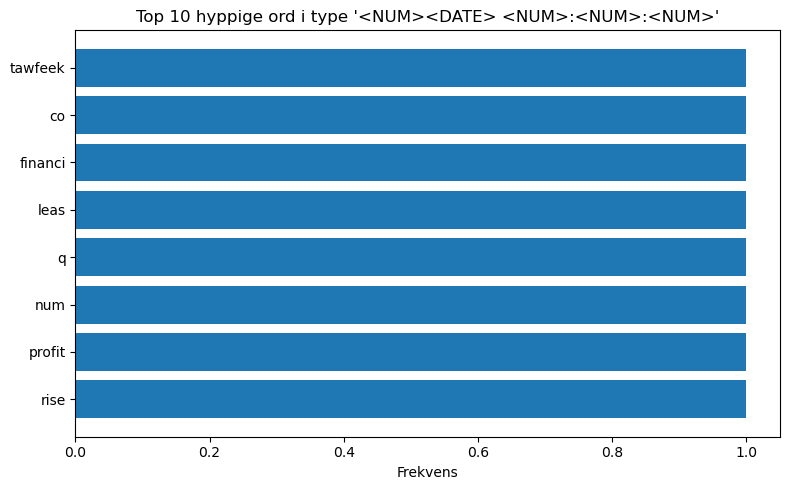

In [14]:
""" 
Top-ord in "content" according to "type" distribution barplot
"""
from collections import defaultdict, Counter
type_word_counters = defaultdict(Counter)

# Læs i chunks og saml ord pr. type
for chunk in pd.read_csv(cleaned_file, chunksize=chunksize, low_memory=False):
    if 'type' in chunk.columns and 'content' in chunk.columns:
        chunk = chunk.dropna(subset=['type', 'content'])

        # Konverter content til faktiske Python-lister, hvis det er gemt som tekst
        chunk['content'] = chunk['content'].apply(ast.literal_eval)

        for _, row in chunk.iterrows():
            t = row['type']
            tokens = row['content']
            if isinstance(tokens, list):
                type_word_counters[t].update(tokens)

# Plot top 10 ord pr. type
for t, counter in type_word_counters.items():
    top_words = counter.most_common(10)
    words, freqs = zip(*top_words)

    plt.figure(figsize=(8, 5))
    plt.barh(words, freqs)
    plt.xlabel("Frekvens")
    plt.title(f"Top 10 hyppige ord i type '{t}'")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()